# Grounding Dino test 

## Install all the dependencies

In [1]:
!pip install diffusers accelerate segment_anything torch transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 48.1 MB/s eta 0:00:00


## Configure GroundinDINO

Here we configure following the instruction of the oficial github [repository](https://github.com/IDEA-Research/GroundingDINO)

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math
from typing import List
from PIL import Image
from skimage import measure
import cv2

import torch
import transformers
import accelerate

import os
import sys
import torch
from diffusers import StableDiffusionInpaintPipeline
from segment_anything import SamPredictor, sam_model_registry, SamAutomaticMaskGenerator


HOME = os.getcwd()
print("Home directory", HOME)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print("Device is: CUDA") if torch.cuda.is_available else print("Device is: CPU")


2024-06-13 20:48:43.111802: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-13 20:48:43.111941: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-13 20:48:43.237429: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/diffusers/models/transformers/transformer_2d.py:34: FutureWarning: `Transformer2DModelOutput` is deprecated and will be removed in version 1.0.0. Importing `Transformer2DModelOutput` from `diffusers.models.transformer_2d` is deprecated and this will be removed in a future version. Please use `from diffusers.models.modeling_

Home directory /kaggle/working
Device is: CUDA


In [3]:
import platform
import sys
import subprocess

# Check Operating System
os_info = platform.platform()

# Check Python Version
python_version = sys.version

# Check CUDA Version
try:
    cuda_version = subprocess.check_output(['nvcc', '--version']).decode('utf-8')
except FileNotFoundError:
    cuda_version = "nvcc not found - CUDA might not be installed."

# Check System Architecture
architecture = platform.machine()

# Check PyTorch Version
try:
    import torch
    pytorch_version = torch.__version__
except ImportError:
    pytorch_version = "PyTorch not installed."

# Print all the information
print(f"Operating System: {os_info}")
print(f"Python Version: {python_version}")
print(f"CUDA Version: {cuda_version}")
print(f"System Architecture: {architecture}")
print(f"PyTorch Version: {pytorch_version}")


Operating System: Linux-5.15.133+-x86_64-with-glibc2.31
Python Version: 3.10.13 | packaged by conda-forge | (main, Dec 23 2023, 15:36:39) [GCC 12.3.0]
CUDA Version: nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Mon_Apr__3_17:16:06_PDT_2023
Cuda compilation tools, release 12.1, V12.1.105
Build cuda_12.1.r12.1/compiler.32688072_0

System Architecture: x86_64
PyTorch Version: 2.1.2


Download the model and their respective weights

In [4]:
!git clone https://github.com/IDEA-Research/GroundingDINO.git
%cd {HOME}/GroundingDINO
!pip install -q -e .
%cd {HOME}

!mkdir -p {HOME}/weights
%cd {HOME}/weights
!wget -q https://github.com/IDEA-Research/GroundingDINO/releases/download/v0.1.0-alpha/groundingdino_swint_ogc.pth


/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


Cloning into 'GroundingDINO'...
remote: Enumerating objects: 443, done.
remote: Counting objects: 100% (212/212), done.
remote: Compressing objects: 100% (82/82), done.
remote: Total 443 (delta 158), reused 139 (delta 130), pack-reused 231
Receiving objects: 100% (443/443), 12.86 MiB | 26.03 MiB/s, done.
Resolving deltas: 100% (229/229), done.
/kaggle/working/GroundingDINO
/kaggle/working
/kaggle/working/weights


Set the configuration and weights for DINO

In [5]:
GROUNDING_DINO_CONFIG_PATH = os.path.join(
    HOME, "GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py"
)
print(
    GROUNDING_DINO_CONFIG_PATH, "; exist:", os.path.isfile(GROUNDING_DINO_CONFIG_PATH)
)

GROUNDING_DINO_CHECKPOINT_PATH = os.path.join(
    HOME, "weights", "groundingdino_swint_ogc.pth"
)
print(
    GROUNDING_DINO_CHECKPOINT_PATH,
    "; exist:",
    os.path.isfile(GROUNDING_DINO_CHECKPOINT_PATH),
)

/kaggle/working/GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py ; exist: True
/kaggle/working/weights/groundingdino_swint_ogc.pth ; exist: True


In [6]:
%cd {HOME}/GroundingDINO
from groundingdino.util.inference import (
    load_model,
    load_image,
    predict,
    annotate,
    Model,
)

grounding_dino_model = Model(
    model_config_path=GROUNDING_DINO_CONFIG_PATH,
    model_checkpoint_path=GROUNDING_DINO_CHECKPOINT_PATH,
)

/kaggle/working/GroundingDINO


final text_encoder_type: bert-base-uncased


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

## Load the model

## Create a Class of groundingDINO



In [7]:
import cv2
import matplotlib.pyplot as plt
from groundingdino.util.inference import Model  # Adjust import based on your actual structure

class GroundingDINO:
    def __init__(self, model):
        self.model = model
        self.BOX_THRESHOLD = 0.35
        self.TEXT_THRESHOLD = 0.25
    
    def predict_with_captions(self, image, text_prompt):
        # Assuming self.model.predict_with_caption returns detections and phrases
        detections, phrases = self.model.predict_with_caption(
            image=image,
            caption=text_prompt,
            box_threshold=self.BOX_THRESHOLD,
            text_threshold=self.TEXT_THRESHOLD,
        )
        return detections, phrases
    
    def visualize_detections(self, image, detections):
        # Visualize detections as before
        image_with_boxes = image.copy()
        for i, box in enumerate(detections.xyxy):
            x_min, y_min, x_max, y_max = map(int, box)
            class_id = detections.data[i]['class_id']
            cv2.rectangle(image_with_boxes, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
            cv2.putText(image_with_boxes, class_id, (x_min, y_min - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (0, 255, 0), 2)

        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image_with_boxes_rgb = cv2.cvtColor(image_with_boxes, cv2.COLOR_BGR2RGB)

        plt.figure(figsize=(10, 10))
        plt.imshow(image_rgb)
        plt.title('Original Image')
        plt.axis('off')
        plt.show()

        plt.figure(figsize=(10, 10))
        plt.imshow(image_with_boxes_rgb)
        plt.title('Image with Detections')
        plt.axis('off')
        plt.show()



# SAM segmentation test

## Configure SAM

In [8]:
%cd {HOME}
!git clone https://github.com/facebookresearch/segment-anything.git

%cd {HOME}/weights
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth

%cd {HOME}

/kaggle/working


Cloning into 'segment-anything'...
remote: Enumerating objects: 295, done.
remote: Total 295 (delta 0), reused 0 (delta 0), pack-reused 295
Receiving objects: 100% (295/295), 18.30 MiB | 13.62 MiB/s, done.
Resolving deltas: 100% (155/155), done.
/kaggle/working/weights
/kaggle/working


## SAM Class

In [9]:
class SAMSegmenter:
    def __init__(self, checkpoint_path, model_type='vit_h', device='cuda'):
        self.checkpoint_path = checkpoint_path
        self.model_type = model_type
        self.device = device
        
        # Instantiate SAM model
        self.sam_model = sam_model_registry[model_type](checkpoint=checkpoint_path).to(device=device)
        
        # Instantiate SAM predictor and mask generator
        self.sam_predictor = SamPredictor(self.sam_model)
        self.mask_generator = SamAutomaticMaskGenerator(self.sam_model)
    
    def segment(self, image, xyxy):
        self.sam_predictor.set_image(image)
        result_masks = []
        for box in xyxy:
            masks, scores, logits = self.sam_predictor.predict(box=box, multimask_output=True)
            index = np.argmax(scores)
            result_masks.append(masks[index])
        return np.array(result_masks)
    
    def make_sam_mask(self, boolean_mask):
        binary_mask = boolean_mask.astype(int)
        contours = measure.find_contours(binary_mask, 0.5)
        mask_points = []
        for contour in contours:
            contour = np.flip(contour, axis=1)
            segmentation = contour.ravel().tolist()
            mask_points.append(segmentation)
        return mask_points
    
    def make_annotations(self, detections):
        if len(detections.xyxy) == 0:
            return None

        annotations = [{"name": f"image id: {detections.tracker_id}", "data": []}]

        for i in range(len(detections.xyxy)):
            annotations[0]["data"].append({
                "label": detections.data[i],
                "score": round((detections.confidence[i] * 100), 2),
                "points": self.make_sam_mask(detections.mask[i]),
            })

        return annotations



## Stable diffusion Class

In [10]:
class StableDiffusionInpainter:
    def __init__(self, pretrained_model_path, torch_dtype=torch.float16, device='cuda'):
        self.pipe = StableDiffusionInpaintPipeline.from_pretrained(
            pretrained_model_path,
            torch_dtype=torch_dtype,
        ).to(device)
        self.device = device

    def generate_image(self, image, mask, prompt, negative_prompt, seed):
        # Resize for inpainting
        w, h = image.size
        in_image = image.resize((512, 512))
        in_mask = mask.resize((512, 512))

        generator = torch.Generator(device=self.device).manual_seed(seed)

        result = self.pipe(
            image=in_image,
            mask_image=in_mask,
            prompt=prompt,
            negative_prompt=negative_prompt,
            generator=generator,
        )
        result = result.images[0]

        return result.resize((w, h))


In [11]:
def load_grounding_dino_model(config_path, checkpoint_path):
    grounding_dino_model = Model(
        model_config_path=config_path,
        model_checkpoint_path=checkpoint_path,
    )
    return grounding_dino_model

def process_image_with_grounding_dino(grounding_dino, image, text_prompt):
    detections, phrases = grounding_dino.predict_with_captions(image, text_prompt)
    for i, phrase in enumerate(phrases):
        detections.data[i] = {'class_id': phrase}
    return detections

def plot_images_grid(images, titles, grid_size, size, cmap="gray"):
    nrows, ncols = grid_size

    if len(images) > nrows * ncols:
        raise ValueError("The number of images exceeds the grid size.")

    if nrows == 1 and ncols == 1:
        fig, ax = plt.subplots(figsize=size)
        if images[0].ndim == 2:
            ax.imshow(images[0], cmap=cmap)
        else:
            ax.imshow(cv2.cvtColor(images[0], cv2.COLOR_BGR2RGB))
        if titles is not None:
            ax.set_title(titles[0])
        ax.axis("off")
    else:
        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=size)
        for idx, ax in enumerate(axes.flat):
            if idx < len(images):
                if images[idx].ndim == 2:
                    ax.imshow(images[idx], cmap=cmap)
                else:
                    ax.imshow(cv2.cvtColor(images[idx], cv2.COLOR_BGR2RGB))
                if titles is not None and idx < len(titles):
                    ax.set_title("{}, mask {}".format(titles[idx], idx))
            ax.axis("off")
        plt.show()


final text_encoder_type: bert-base-uncased


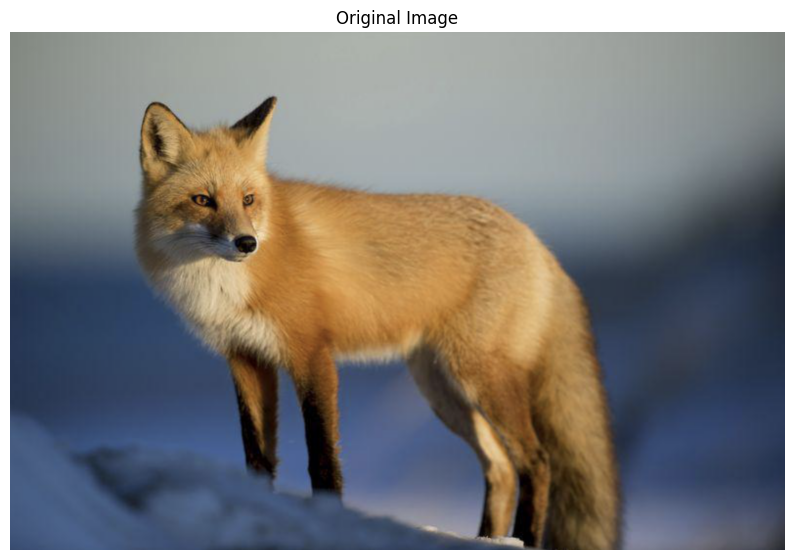

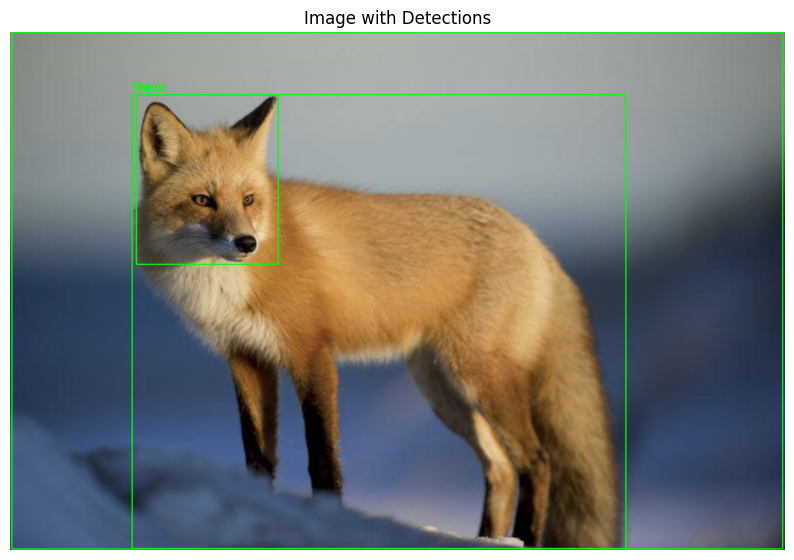

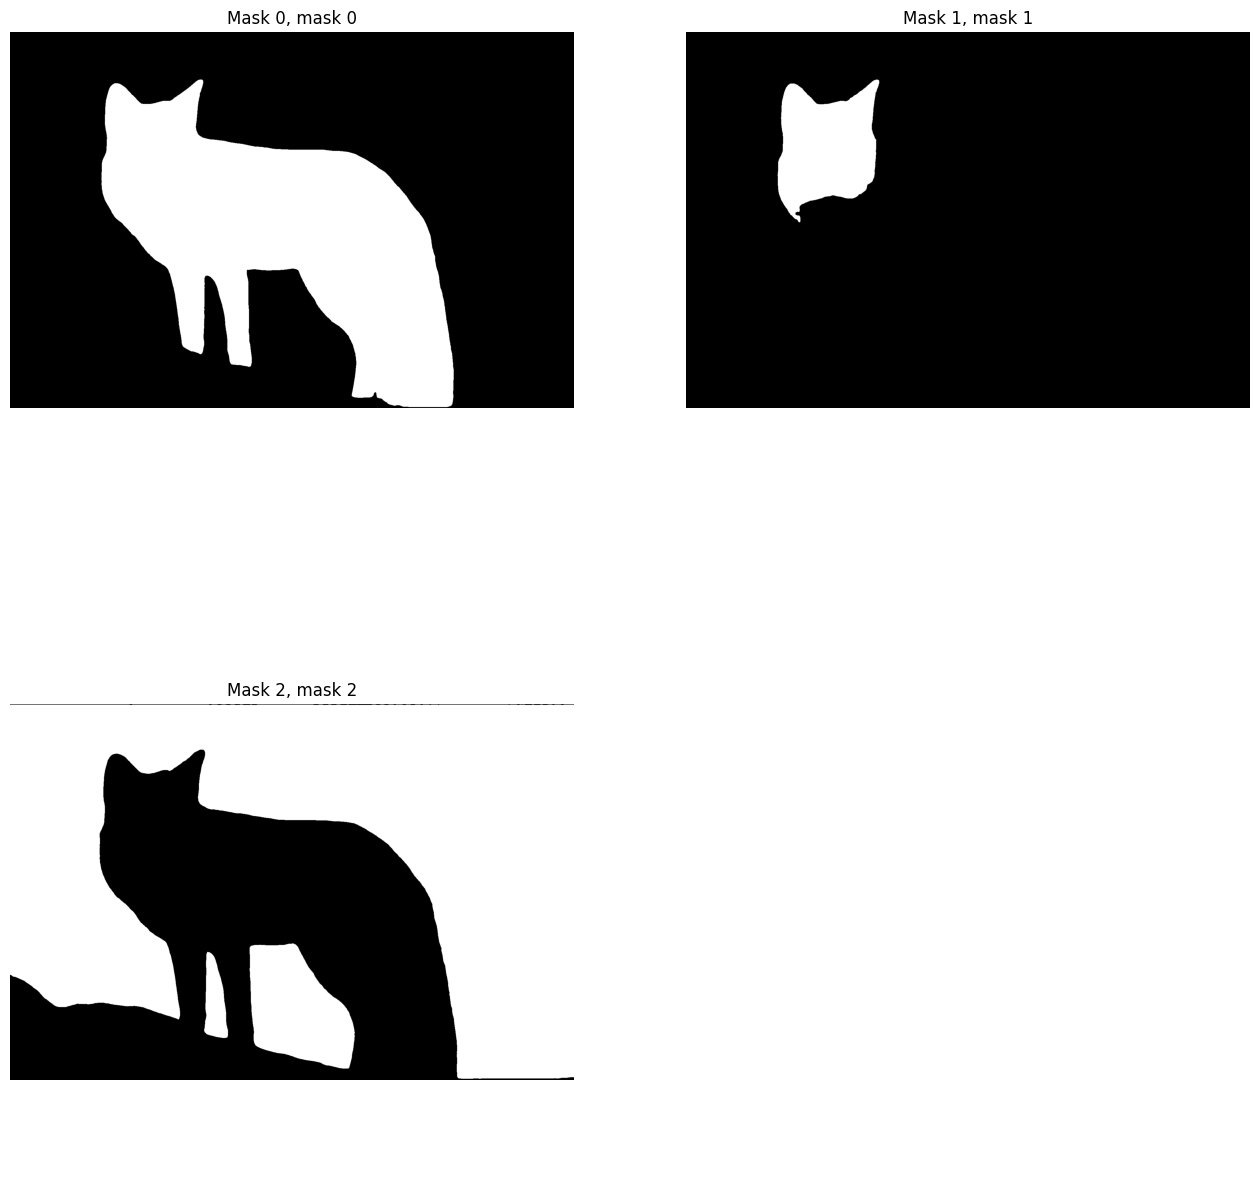

model_index.json:   0%|          | 0.00/544 [00:00<?, ?B/s]

Fetching 13 files:   0%|          | 0/13 [00:00<?, ?it/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

(…)ature_extractor/preprocessor_config.json:   0%|          | 0.00/342 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/308 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/638 [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/829 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/914 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/616 [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

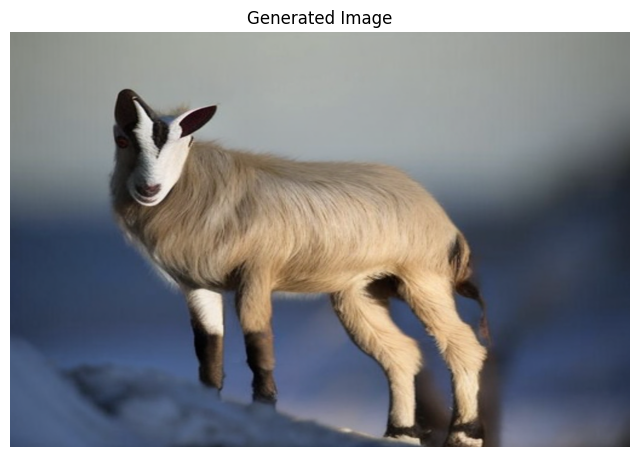

  0%|          | 0/50 [00:00<?, ?it/s]

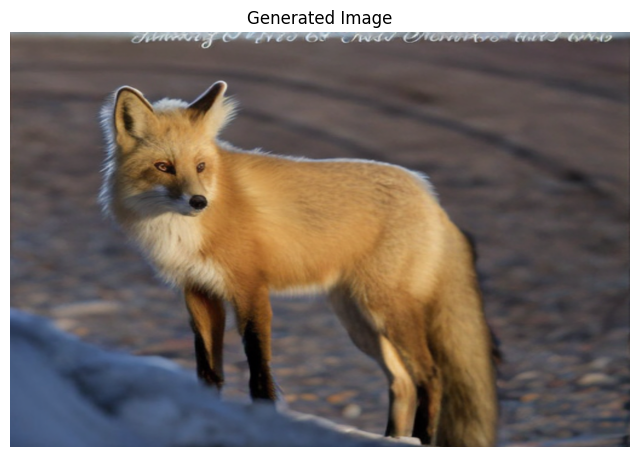

In [12]:
if __name__ == "__main__":
    # Paths and constants
    GROUNDING_DINO_CONFIG_PATH = GROUNDING_DINO_CONFIG_PATH
    GROUNDING_DINO_CHECKPOINT_PATH = GROUNDING_DINO_CHECKPOINT_PATH
    SAM_CHECKPOINT_PATH = "/kaggle/working/weights/sam_vit_h_4b8939.pth"
    STABLE_DIFFUSION_MODEL_PATH = "stabilityai/stable-diffusion-2-inpainting"
    TEXT_PROMPT = "background. fox . head."
    IMAGE_PATH = "/kaggle/input/animals-toy-dataset/fox.jpg"

    # Load GroundingDINO model
    grounding_dino_model = load_grounding_dino_model(GROUNDING_DINO_CONFIG_PATH, GROUNDING_DINO_CHECKPOINT_PATH)
    grounding_dino = GroundingDINO(grounding_dino_model)

    # Load image
    image_bgr = cv2.imread(IMAGE_PATH)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)
    # Process image with GroundingDINO
    detections = process_image_with_grounding_dino(grounding_dino, image_bgr, TEXT_PROMPT)

    # Visualize detections
    grounding_dino.visualize_detections(image_bgr, detections)

    # Instantiate SAMSegmenter
    sam_segmenter = SAMSegmenter(checkpoint_path=SAM_CHECKPOINT_PATH, model_type='vit_h', device='cuda')

    # Segment using SAM
    detections.mask = sam_segmenter.segment(image=image_bgr, xyxy=detections.xyxy)

    # Make annotations
    annotations = sam_segmenter.make_annotations(detections)

    # Prepare for plotting
    grid_size_dimension = int(np.ceil(np.sqrt(len(detections.mask))))
    titles = [class_id for class_id in detections.data]

    # Plot images with masks
    plot_images_grid(
        images=detections.mask,
        titles=[f"Mask {i}" for i in range(len(detections.mask))],
        grid_size=(grid_size_dimension, grid_size_dimension),
        size=(16, 16),
    )
    
    # Initialize StableDiffusionInpainter
    sd_inpainter = StableDiffusionInpainter(STABLE_DIFFUSION_MODEL_PATH, torch_dtype=torch.float16, device='cuda')

    # Prepare inputs for inpainting
    fox_mask = detections.mask[0]
    background_mask = detections.mask[2]
    haead_mask = detections.mask[1]
    image_source_pil = Image.fromarray(image_rgb)
    image_mask_pil = Image.fromarray(fox_mask)

    ip_prompt = "a goat"
    ip_negative_prompt = "low resolution, ugly"
    ip_SEED = 6

    # Generate inpainted image
    generated_image = sd_inpainter.generate_image(
        image=image_source_pil,
        mask=image_mask_pil,
        prompt=ip_prompt,
        negative_prompt=ip_negative_prompt,
        seed=ip_SEED,
    )

    # Display generated image
    plt.figure(figsize=(8, 8))
    plt.imshow(generated_image)
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()
    
    # Generate outpainted image 
    image_source_pil = Image.fromarray(image_rgb)
    image_mask_pil = Image.fromarray(background_mask)
    
    op_prompt = "the Salar of Uyuni"
    op_negative_prompt = "low resolution, ugly"
    op_SEED = 32
    generated_image = sd_inpainter.generate_image(
        image=image_source_pil,
        mask=image_mask_pil,
        prompt=ip_prompt,
        negative_prompt=ip_negative_prompt,
        seed=ip_SEED,
    )
    generated_image
    # Display generated image
    plt.figure(figsize=(8, 8))
    plt.imshow(generated_image)
    plt.title('Generated Image')
    plt.axis('off')
    plt.show()